In [1]:
##   Project: Action Recognition using CNN + LSTM (UCF50 - 18 classes)
##  Goal: Classify videos based on actions using deep learning (TimeDistributed CNN + LSTM)
import pandas as pd
import os
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical , plot_model
from tensorflow.keras.optimizers import Adam

2025-12-02 19:23:21.337681: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764703401.490933      38 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764703401.534108      38 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:

DIRECTORY="/kaggle/input/anomalous-action-detection-dataset/Anomalous Action Detection Dataset( Ano-AAD)/abnormal class"
NORMAL_DIRECTORY="/kaggle/input/anomalous-action-detection-dataset/Anomalous Action Detection Dataset( Ano-AAD)/normal class - normal videos"
dataset_path = os.listdir(DIRECTORY)

label_types = os.listdir(DIRECTORY)
print (label_types)  

label_types_Normal = os.listdir(NORMAL_DIRECTORY)
print (label_types_Normal)  
selected_classes=label_types+label_types_Normal
selected_classes

['Arrest', 'Ill-treatment', 'Explosion', 'violence', 'Traffic Irregularities', 'Attack', 'Burglary', 'Fighting', 'fire-raising']
['Normal Videos']


['Arrest',
 'Ill-treatment',
 'Explosion',
 'violence',
 'Traffic Irregularities',
 'Attack',
 'Burglary',
 'Fighting',
 'fire-raising',
 'Normal Videos']

In [3]:
rooms = []

for item in dataset_path:
 # Get all the file names
 all_rooms = os.listdir(DIRECTORY + '/' +item)

 # Add them to the list
 for room in all_rooms:
    rooms.append(( str(DIRECTORY + '/' +item) + '/' + room,item))

for item in label_types_Normal:
 # Get all the file names
 all_rooms = os.listdir(NORMAL_DIRECTORY + '/' +item)

 # Add them to the list
 for room in all_rooms:
    rooms.append(( str(NORMAL_DIRECTORY + '/' +item) + '/' + room,item))
    
# Build a dataframe        
train_df = pd.DataFrame(data=rooms, columns=[ 'video_path','label'])
print(train_df.head())
print(train_df.tail())

                                          video_path   label
0  /kaggle/input/anomalous-action-detection-datas...  Arrest
1  /kaggle/input/anomalous-action-detection-datas...  Arrest
2  /kaggle/input/anomalous-action-detection-datas...  Arrest
3  /kaggle/input/anomalous-action-detection-datas...  Arrest
4  /kaggle/input/anomalous-action-detection-datas...  Arrest
                                            video_path          label
390  /kaggle/input/anomalous-action-detection-datas...  Normal Videos
391  /kaggle/input/anomalous-action-detection-datas...  Normal Videos
392  /kaggle/input/anomalous-action-detection-datas...  Normal Videos
393  /kaggle/input/anomalous-action-detection-datas...  Normal Videos
394  /kaggle/input/anomalous-action-detection-datas...  Normal Videos


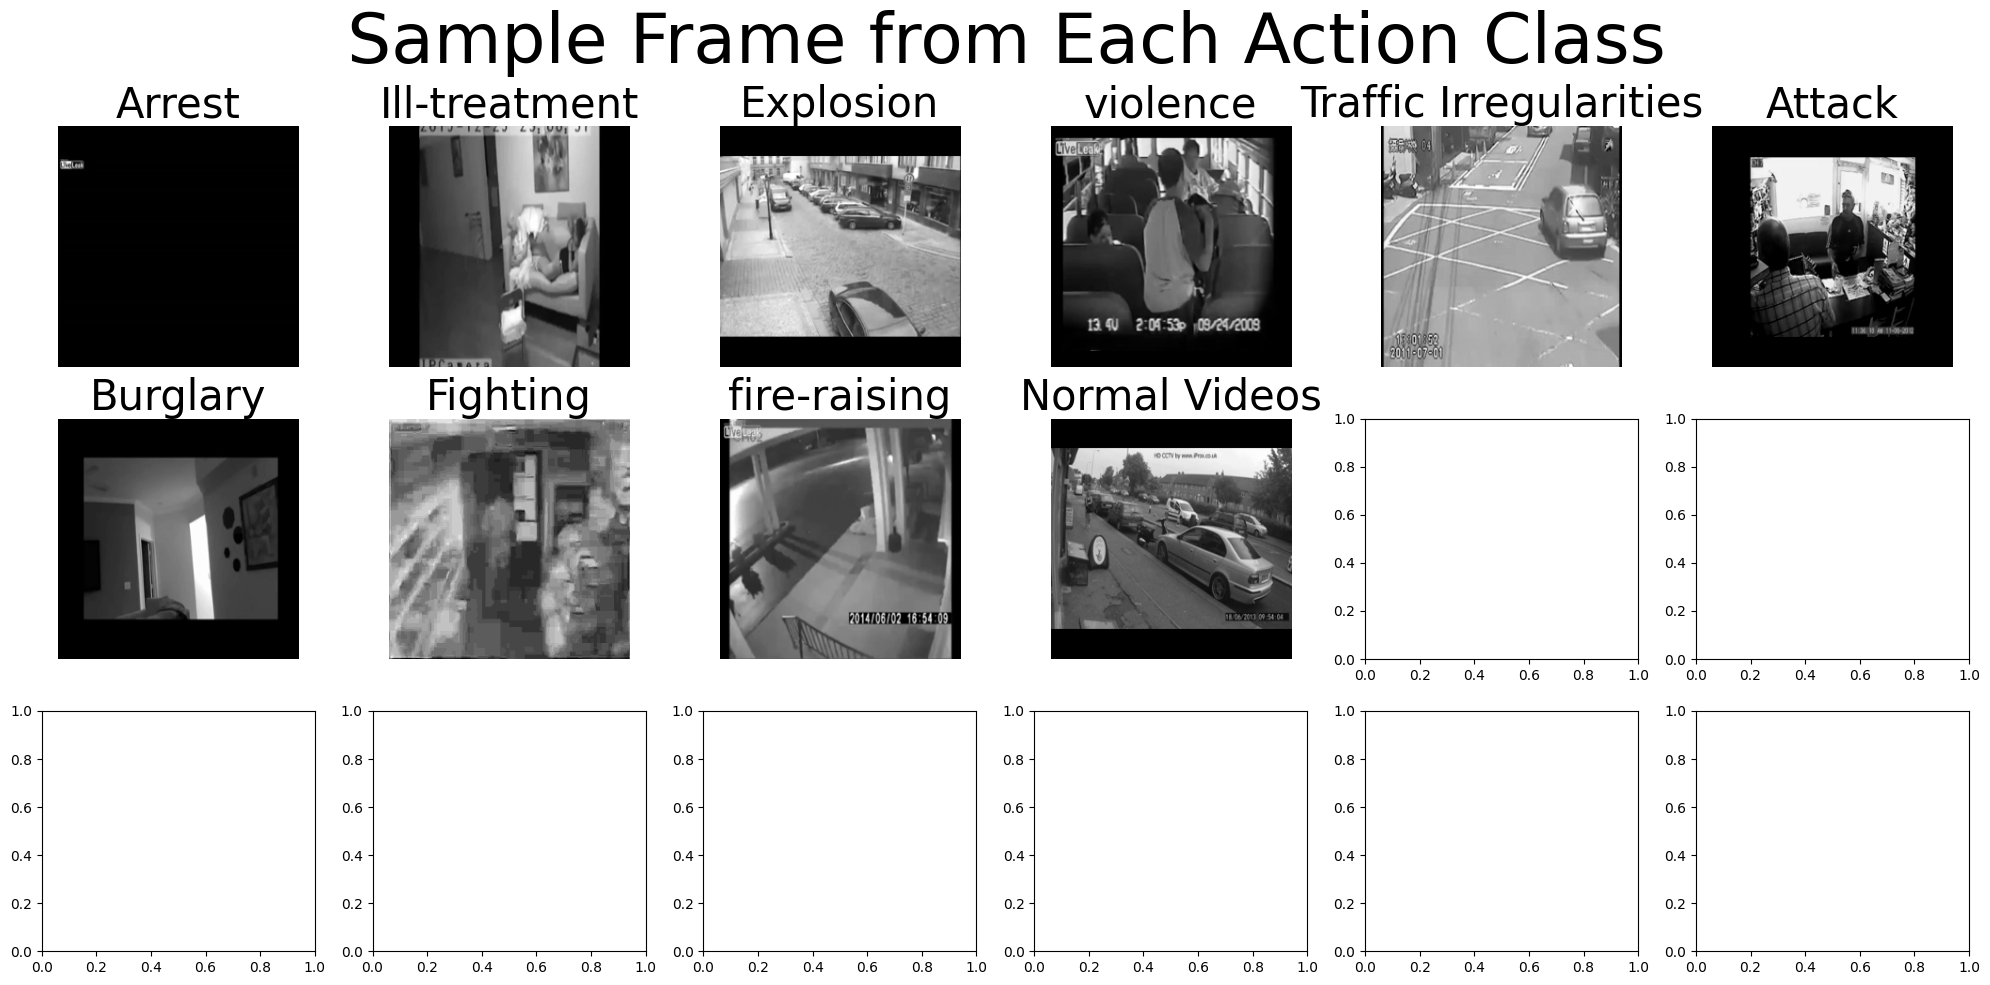

In [4]:
# Show 1 frame from 1 video of each class

def show_sample_frames(classes, dataset_path):
    fig, axes = plt.subplots(3, 6, figsize=(20, 10))  # 3 rows and 6 columns
    axes = axes.flatten()  # make it easy to loop over

    for i, cls in enumerate(classes):
        # Load first video from the class folder
        if(cls=="Normal Videos"):
            video_path = os.path.join(NORMAL_DIRECTORY, cls, os.listdir(os.path.join(NORMAL_DIRECTORY, cls))[0])
        else:
            video_path = os.path.join(dataset_path, cls, os.listdir(os.path.join(dataset_path, cls))[0])
        cap = cv2.VideoCapture(video_path) #think of cap like a video player that's paused and ready to play frame by frame.

        # ret: a boolean (True/False) — it’s True if a frame was read successfully
        # frame: the actual image/frame (as a NumPy array)
        ret, frame = cap.read()
        cap.release() # This closes the video file after you're done

        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            frame = cv2.resize(frame, (256, 256))
            axes[i].imshow(frame, cmap='gray')
            axes[i].set_title(cls, fontsize=30)
        axes[i].axis('off')
             

    plt.suptitle(" Sample Frame from Each Action Class", fontsize=50)
    plt.tight_layout()
    plt.show()

# Calling
show_sample_frames(selected_classes, DIRECTORY)


In [5]:
#  Extract fixed number of frames from each video
# For simplicity and speed, we’ll extract 20 frames per video
Frame_Size=64

def extract_frames(video_path, num_frames=40):
    frames = []
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_interval = max(total_frames // num_frames, 1)
    
    count = 0
    while len(frames) < num_frames and cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if count % frame_interval == 0:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = cv2.resize(frame, (Frame_Size, Frame_Size))
            # frame = np.expand_dims(frame, axis=0) # Add channel dimension
            frame = frame / 255.0  # Normalize pixel values
            frames.append(frame)
        count += 1
    cap.release()

    # Pad with last frame if video too short
    while len(frames) < num_frames:
        frames.append(frames[-1])
    
    return np.array(frames)


In [6]:
# Loop through videos in selected classes and extract frames
X = []
y = []

for class_index, cls in enumerate(selected_classes):
    if(cls=="Normal Videos"):
        class_path = os.path.join(NORMAL_DIRECTORY, cls)
        videos = os.listdir(class_path)  
        videos=videos[:30]
    else:
        class_path = os.path.join(DIRECTORY, cls)
        videos = os.listdir(class_path)  
        videos=videos[:30]
    for video in videos:
        video_path = os.path.join(class_path, video)
        frames = extract_frames(video_path, num_frames=40)
        if frames.shape == (40, Frame_Size, Frame_Size,3):  # Ensure consistent shape
            X.append(frames)
            y.append(class_index)


In [7]:

X = np.array(X)
y = to_categorical(y) # One-Hot

print(" Data Loaded:")
print("X shape:", X.shape)  # (samples, time_steps, height, width, channels)
print("y shape:", y.shape)  # (samples, num_classes)


 Data Loaded:
X shape: (279, 40, 64, 64, 3)
y shape: (279, 10)


In [8]:
print("y shape:", y.shape) 

y shape: (279, 10)


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

X, y = shuffle(X, y, random_state=42)  # shuffle the entire dataset first

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

print("Training videos:", X_train.shape[0])
print("Testing videos:", X_test.shape[0])


Training videos: 223
Testing videos: 56


In [10]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout
# from tensorflow.keras.optimizers import Adam

# model = Sequential()

# # CNN feature extractor applied frame-wise (spatial features)
# model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same'),
#                           input_shape=(40, 64, 64, 3)))
# model.add(TimeDistributed(MaxPooling2D((2, 2))))
# model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same')))
# model.add(TimeDistributed(MaxPooling2D((2, 2))))
# model.add(TimeDistributed(Flatten()))

# # LSTM for temporal feature extraction (temporal features)
# model.add(LSTM(64, return_sequences=False))
# model.add(Dropout(0.5))

# # Final classification layer
# model.add(Dense(len(selected_classes), activation='softmax'))

# # Compile the model
# model.compile(loss='categorical_crossentropy',
#               optimizer=Adam(learning_rate=0.003),
#               metrics=['accuracy'])

# # Freeze CNN feature extractor layers if needed
# for layer in model.layers[:4]:
#     layer.trainable = False


In [11]:
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, sequence_length, output_dim):
        super().__init__()
        self.position_embeddings = tf.keras.layers.Embedding(sequence_length, output_dim)
    
    def call(self, inputs):
        length = tf.shape(inputs)[1]
        positions = tf.range(0, length, 1)
        pos_embed = self.position_embeddings(positions)
        return inputs + pos_embed

In [12]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, TimeDistributed, LSTM, Dense, Dropout, Flatten, LayerNormalization, MultiHeadAttention
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0
import tensorflow as tf
import keras
# selected_classes=10

@keras.saving.register_keras_serializable()
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, sequence_length, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.sequence_length = sequence_length
        self.output_dim = output_dim
        self.position_embeddings = tf.keras.layers.Embedding(
            input_dim=sequence_length, 
            output_dim=output_dim
        )

    def call(self, inputs):
        length = tf.shape(inputs)[1]
        positions = tf.range(start=0, limit=length, delta=1)
        pos_embed = self.position_embeddings(positions)
        return inputs + pos_embed

    def get_config(self):
        config = super().get_config()
        config.update({
            "sequence_length": self.sequence_length,
            "output_dim": self.output_dim
        })
        return config


def temporal_transformer(x, seq_len=40, num_heads=2, proj_dim=64, ff_dim=32):
    dim = x.shape[-1]
    x = Dense(proj_dim)(x)
    pos = PositionalEmbedding(seq_len, proj_dim)(x)
    n1 = LayerNormalization()(pos)
    attn = MultiHeadAttention(num_heads=num_heads, key_dim=proj_dim//num_heads)(n1, n1)
    add1 = pos + attn
    n2 = LayerNormalization()(add1)
    ff = Dense(ff_dim, activation='relu')(n2)
    return ff

# CNN backbone for spatial feature extraction
base = EfficientNetB0(
    include_top=False,
    weights='/kaggle/input/model1/other/default/1/efficientnetb0_notop.h5',
    input_shape=(Frame_Size, Frame_Size, 3),
    # pooling='avg'  # This is key - it gives us a feature vector per frame
)

# Model architecture
video_in = Input(shape=(40, Frame_Size, Frame_Size, 3))
x = tf.keras.layers.Flatten()(base.output)
x = TimeDistributed(base)(video_in)  # Now shape: (batch, 40, feature_dim)
x = TimeDistributed(Flatten())(x)
x = temporal_transformer(x, seq_len=40, num_heads=2, ff_dim=8)

x = LSTM(64)(x)
x = Dropout(0.5)(x)

# Classification head
out = Dense(len(selected_classes), activation='softmax')(x)

model = Model(video_in, out)
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(0.003),  # Consider starting with a lower learning rate
    metrics=['accuracy']
)

# model.summary()

def extract_frames(video_path, max_frames=40, size=(Frame_Size,Frame_Size)):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret or len(frames) >= max_frames:
            break
        frame = cv2.resize(frame, size)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = frame.astype(np.float32) / 255.0
        frames.append(frame)
    cap.release()
    if len(frames) == 0:
        return np.zeros((max_frames, size[1], size[0], 3), dtype=np.float32)
    while len(frames) < max_frames:
        frames.append(frames[-1])
    return np.array(frames[:max_frames])


2025-12-02 19:26:44.479583: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


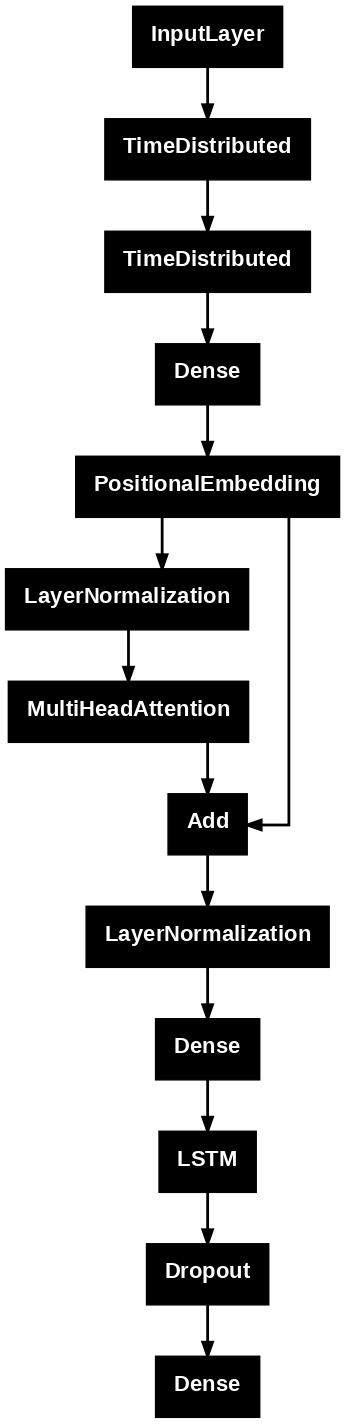

In [13]:
plot_model(model,dpi=100)

In [14]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 40, 64,    │          0 │ -                 │
│ (InputLayer)        │ 64, 3)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 40, 2, 2,  │  4,049,571 │ input_layer_1[0]… │
│ (TimeDistributed)   │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, 40, 5120)  │          0 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 40, 64)    │    327,744 │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_embeddi… │ (None, 40, 64)    │      2,560 │ dense[0][0]       │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 40, 64)    │        128 │ positional_embed… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 40, 64)    │     16,640 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 40, 64)    │          0 │ positional_embed… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 40, 64)    │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 40, 8)     │        520 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 64)        │     18,688 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 10)        │        650 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,416,629 (16.85 MB)

 Trainable params: 4,374,606 (16.69 MB)

 Non-trainable params: 42,023 (164.16 KB)

ValueError: File not found: filepath=crim_model.keras. Please ensure the file is an accessible `.keras` zip file.

In [16]:
#  Train the model
# X_train.shape 
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    'best_model.h5',        # path to save the model
    monitor='val_loss',     # metric to monitor
    save_best_only=True,    # save only when the model improves
    mode='min',             # minimize val_loss
    verbose=1
)
history = model.fit(X_train, y_train, epochs=40, validation_data=(X_test, y_test), batch_size=16,callbacks=[checkpoint])


Epoch 1/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.0811 - loss: 2.3752
Epoch 1: val_loss improved from inf to 2.31883, saving model to best_model.h5
14/14 ━━━━━━━━━━━━━━━━━━━━ 948s 12s/step - accuracy: 0.0817 - loss: 2.3735 - val_accuracy: 0.1250 - val_loss: 2.3188
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.1537 - loss: 2.2825
Epoch 2: val_loss improved from 2.31883 to 2.31386, saving model to best_model.h5
14/14 ━━━━━━━━━━━━━━━━━━━━ 55s 4s/step - accuracy: 0.1527 - loss: 2.2841 - val_accuracy: 0.0357 - val_loss: 2.3139
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.1079 - loss: 2.2507
Epoch 3: val_loss did not improve from 2.31386
14/14 ━━━━━━━━━━━━━━━━━━━━ 53s 4s/step - accuracy: 0.1103 - loss: 2.2509 - val_accuracy: 0.1071 - val_loss: 2.5079
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.2230 - loss: 2.2163
Epoch 4: val_loss did not improve from 2.31386
14/14 ━━━━━━━━━━━━━━━━━━━━ 55s 4s/step - accuracy: 0.2198 - loss: 2

In [17]:
model.save("Mohib.keras")

In [46]:
def recurrent_gradcam_for_your_model(model, video, conv_layer_name="time_distributed"):
    conv_model = tf.keras.Model(
        inputs=model.input,
        outputs=model.get_layer(conv_layer_name).output
    )
    print("model layer output ", model.get_layer(conv_layer_name).output)

    conv_maps = conv_model(video)
    print("conv map ", conv_maps)
    out = model(video)
    print("Model out", out)

    with tf.GradientTape() as t:
        t.watch(conv_maps)
        out = model(video)
        cls = tf.argmax(out, axis=-1)
        score = tf.reduce_sum(out * tf.one_hot(cls, out.shape[-1]), axis=-1)  # fix here

    grads = t.gradient(score, conv_maps)
    grads = tf.nn.relu(grads)

    weights = tf.reduce_mean(grads, axis=[2, 3])
    weights = tf.reshape(weights, (-1, conv_maps.shape[1], 1, 1, conv_maps.shape[-1]))

    heat = tf.reduce_sum(weights * conv_maps, axis=-1)
    heat = tf.nn.relu(heat)

    heat = heat[0]  # remove batch
    heat = tf.transpose(heat, [0, 1])

    heat = (heat - tf.reduce_min(heat)) / (tf.reduce_max(heat) + 1e-8)
    return heat.numpy()

# your original video
video = X_train[0]  # replace with real video

# add batch dimension
video = np.expand_dims(video, axis=0)  # now shape is (1, 40, 64, 64, 3)

# run Grad-CAM
heatmaps = recurrent_gradcam_for_your_model(
    model,
    video,
    conv_layer_name="time_distributed"  # adjust if your conv layer has a different name
)

print(len(heatmaps))        # should be 40 (one heatmap per frame)
print(heatmaps[0].shape)    # shape of each heatmap (depends on CNN output, e.g., 2x2)


model layer output  <KerasTensor shape=(None, 40, 2, 2, 1280), dtype=float32, sparse=False, name=keras_tensor_241>
conv map  tf.Tensor(
[[[[[-0.22072558 -0.08161503 -0.06844448 ... -0.11128017 -0.03198142
     -0.2589649 ]
    [-0.18189986 -0.10512245 -0.25471556 ... -0.0864993  -0.22572291
     -0.21042666]]

   [[-0.1443855  -0.16999948 -0.27589172 ... -0.17612673 -0.14973983
     -0.26874408]
    [-0.10639038 -0.16651857 -0.14014173 ... -0.13671753 -0.27089646
     -0.16717036]]]


  [[[-0.2248661  -0.08276717 -0.24576275 ... -0.14944041 -0.18878584
     -0.25299516]
    [-0.2188063  -0.08960513 -0.21034895 ... -0.10774416 -0.26790756
     -0.21298271]]

   [[-0.1818871  -0.14834005 -0.27322203 ... -0.2043224  -0.2176883
     -0.27837327]
    [-0.18258868 -0.1212485  -0.17024983 ... -0.16356237 -0.2768548
     -0.22299437]]]


  [[[-0.21483874 -0.07566217 -0.27445617 ... -0.13085794 -0.23849533
     -0.2705522 ]
    [-0.1889621  -0.06881885 -0.17279638 ... -0.06537925 -0.24957445
  

ValueError: Attempt to convert a value (None) with an unsupported type (<class 'NoneType'>) to a Tensor.

In [77]:
X_train[0].shape

(40, 64, 64, 3)

In [2]:
#  Training vs Validation Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()    
plt.grid(True)
plt.show()

#  Training vs Validation Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


NameError: name 'plt' is not defined

2/2 ━━━━━━━━━━━━━━━━━━━━ 347s 181s/step


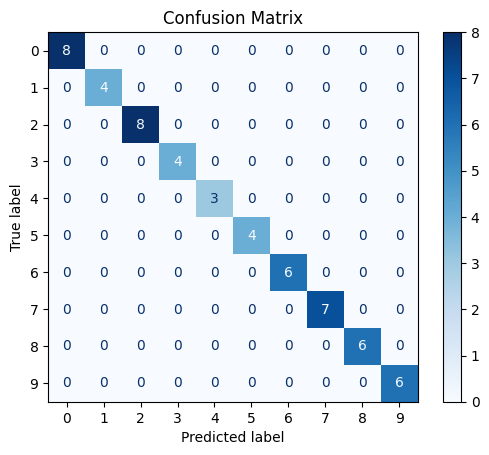

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Get model predictions on test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_test, axis=1)  # if it's a classification model
y_true = np.argmax(y_test, axis=1)          # if y_test is one-hot encoded

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()


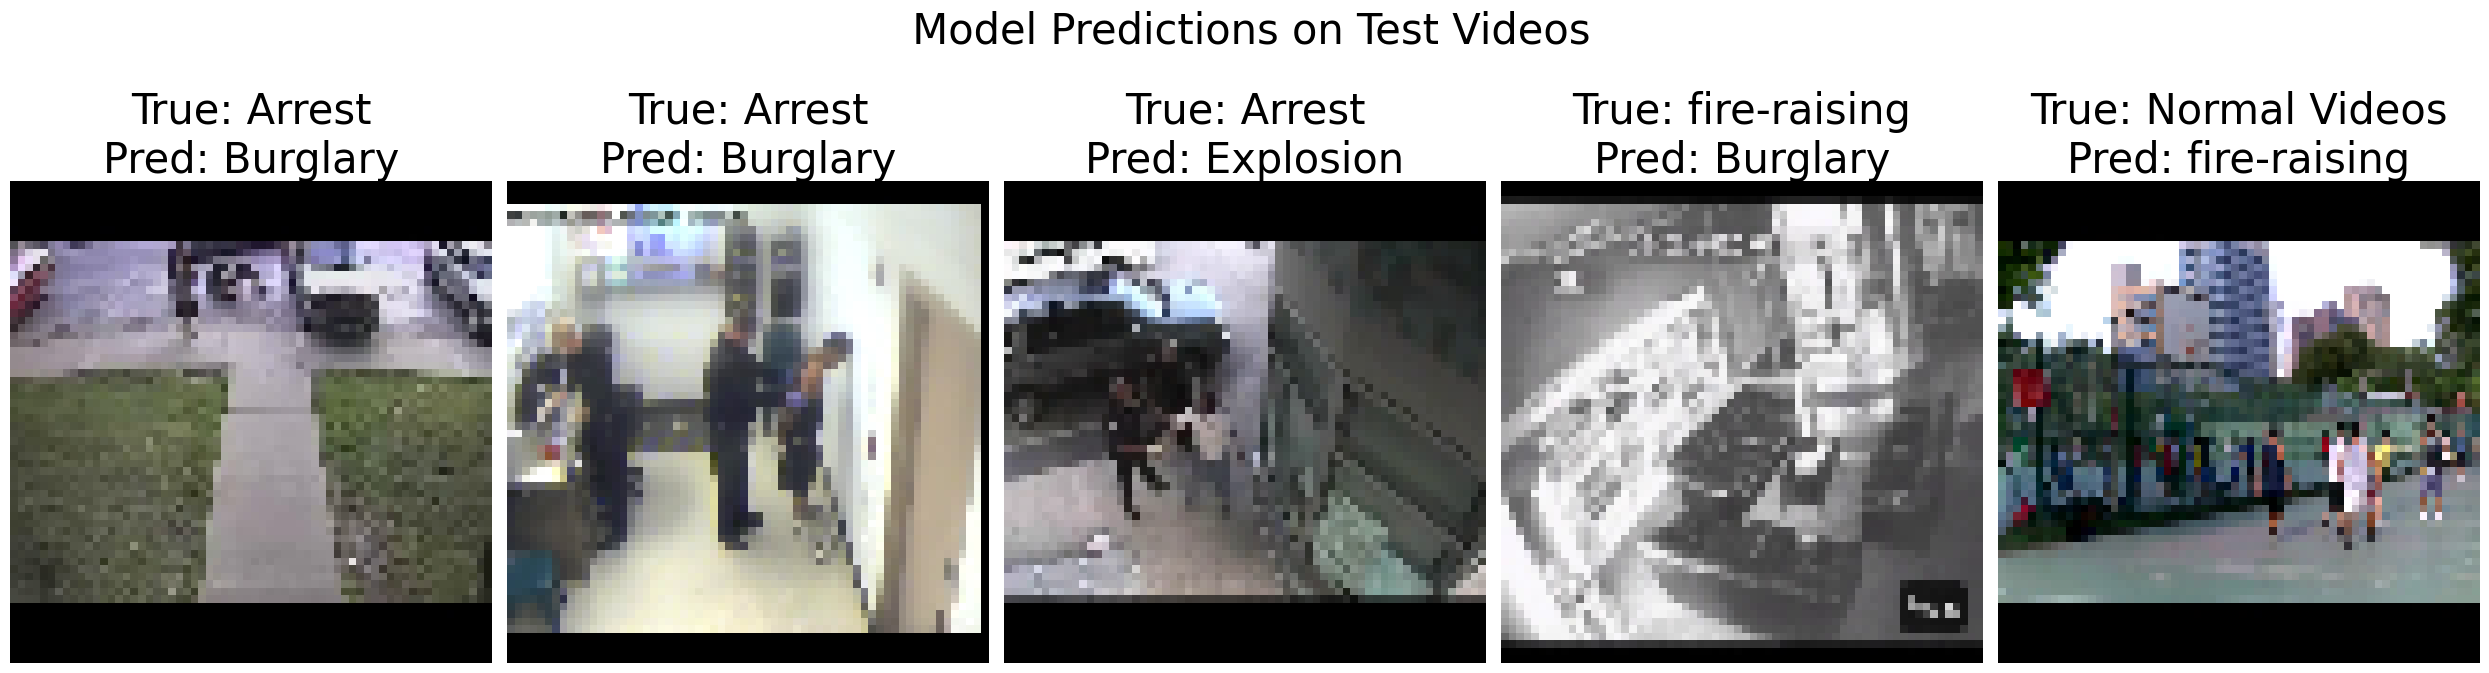

In [32]:
#  Visualize model predictions on 5 test videos (larger images)
def show_predictions(model, X_test, y_test, class_names):
    # Get 5 random indices
    indices = np.random.choice(len(X_test), 5, replace=False)
    
    # Bigger canvas size
    fig, axes = plt.subplots(1, 5, figsize=(25, 8))  #  Wider and taller

    for i, idx in enumerate(indices):
        video = X_test[idx]
        true_label = class_names[np.argmax(y_test[idx])]

        # Predict
        prediction = model.predict(np.expand_dims(video, axis=0), verbose=0)
        predicted_label = class_names[np.argmax(prediction)]

        # Get middle frame and denormalize
        mid_frame = video[len(video) // 2]
        mid_frame = (mid_frame * 255).astype(np.uint8)

        # Optional: remove resizing if frame is already big enough
        # frame = cv2.resize(mid_frame, (256, 256))  # or skip this
        frame = mid_frame  # Show full original frame size

        # Plot
        axes[i].imshow(frame)
        axes[i].set_title(f"True: {true_label}\nPred: {predicted_label}", fontsize=30)
        axes[i].axis('off')

    plt.suptitle(" Model Predictions on Test Videos", fontsize=30)
    plt.tight_layout()
    plt.show()

#  Run it
show_predictions(model, X_test, y_test, selected_classes)


In [28]:
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Convert predictions and labels back to class indices
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Print overall accuracy
accuracy = accuracy_score(y_true, y_pred_classes)
print("Overall Accuracy:", accuracy)

# Print precision, recall, and F1-score for each class
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred_classes))


7/7 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step
Overall Accuracy: 0.15246636771300448

Classification Report:

              precision    recall  f1-score   support

           0       0.57      0.18      0.28        22
           1       0.43      0.12      0.18        26
           2       0.17      0.05      0.07        22
           3       0.22      0.09      0.13        22
           4       0.00      0.00      0.00        10
           5       1.00      0.12      0.21        26
           6       0.13      0.67      0.22        24
           7       0.17      0.04      0.07        23
           8       0.02      0.04      0.03        24
           9       0.50      0.12      0.20        24

    accuracy                           0.15       223
   macro avg       0.32      0.14      0.14       223
weighted avg       0.35      0.15      0.15       223



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step
Overall Accuracy: 0.08928571428571429

Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.00      0.00      0.00         4
           2       0.33      0.12      0.18         8
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00         4
           6       0.10      0.50      0.17         6
           7       0.00      0.00      0.00         7
           8       0.06      0.17      0.08         6
           9       0.00      0.00      0.00         6

    accuracy                           0.09        56
   macro avg       0.05      0.08      0.04        56
weighted avg       0.06      0.09      0.05        56



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


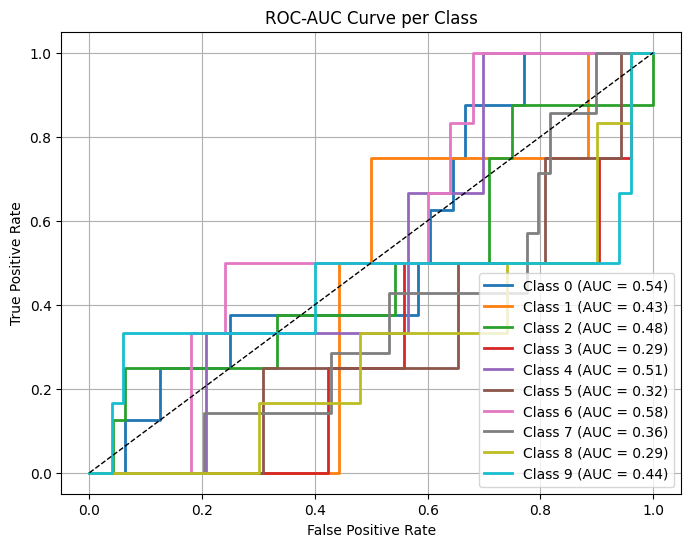

Overall Macro ROC-AUC: 0.4242


In [29]:
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# Predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# === Performance Metrics ===
print("Overall Accuracy:", accuracy_score(y_true, y_pred_classes))
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred_classes))

# === AUC (per class and micro/macro averages) ===
n_classes = y_test.shape[1]
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro-average AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# === Plot AUC Curve ===
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.title('ROC-AUC Curve per Class')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# === Overall ROC-AUC ===
overall_auc = roc_auc_score(y_test, y_pred, average='macro')
print(f"Overall Macro ROC-AUC: {overall_auc:.4f}")
